In [89]:
import os 
import mne
import numpy as np
import torch
import torch.nn as nn
import torchvision
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [106]:
def scale_clamp(X: np.ndarray, clamp_lim: float = 5.0, clamp: bool = True) -> np.ndarray:
  X = X.reshape(X.shape[0], -1)
  X = RobustScaler().fit_transform(X)
  if clamp:
      X = X.clip(min=-clamp_lim, max=clamp_lim)
  return X.squeeze()


class meg_dataset(torch.utils.data.Dataset):
  def __init__(self, root, s: str):
    self.root = root
    nights = ['night1', 'night2', 'night3', 'night4']

    self.all_meg_data = []
    self.all_epochs = []
    for night in nights:
      data_path_folder = os.path.join(self.root, rf'{s}\{night}')
      wm = os.listdir(data_path_folder)[-1]
      self.data_path = os.path.join(self.root, rf'{s}\{night}\{wm}')

      raw = mne.io.read_raw_ctf(self.data_path, preload=True)
      raw.pick_types(meg=True, stim=True, eeg=True, ref_meg=True)
      events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True)
      event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

      events[:,2] = events[:,2] - 255
      sel = np.where(events[:, 2] <= 255)[0]
      events = events[sel, :]
      picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                              exclude='bads')
      self.epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                          baseline=None, preload=True)
      #self.epochs.resample(120)   ### filtert es schonb?
      self.epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
      self.meg_data = torch.from_numpy(self.epochs.get_data(picks='meg')).to(torch.float32)
      self.all_meg_data.append(self.meg_data)
      self.all_epochs.append(self.epochs)

    self.all_meg_data = torch.cat(self.all_meg_data, dim=0)
    for ep in self.all_epochs:
      ep.info['dev_head_t'] = self.all_epochs[0].info['dev_head_t']
    self.all_epochs = mne.concatenate_epochs(self.all_epochs)
    
  def __len__(self):
    return len(self.all_meg_data)
  
  def __getitem__(self, idx):
    return self.all_meg_data[idx, :, :], self.all_epochs.events[idx, 2], self.all_epochs[idx]

In [49]:

class CustomBatchNorm1d(nn.BatchNorm1d):
    def forward(self, input):
        if input.size(0) == 1:
            return input
        return super().forward(input)

class NaiveModel(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()

        self.backbone = backbone

        out_features = list(self.backbone.modules())[-1].out_features
        
        self.cls_head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(out_features, 512),
            CustomBatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            CustomBatchNorm1d(128),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            CustomBatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(64, 2),
        )

    def forward(self, x):
        x = self.backbone(x)
        
        output = self.cls_head(x)
        return output

In [73]:
import sys
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from functools import partial
from typing import Optional, Union, Callable, List, Tuple
from termcolor import cprint


class SpatialAttention(nn.Module):
    def __init__(
        self, loc: torch.Tensor, D1: int, K: int, d_drop: float, flat: bool = True
    ):
        super().__init__()

        self.flat = flat

        # TODO: Check if those two are identical.
        x, y = loc.T
        if self.flat:  # Implementation version 1
            self.z_re = nn.Parameter(torch.Tensor(D1, K, K))
            self.z_im = nn.Parameter(torch.Tensor(D1, K, K))
            nn.init.kaiming_uniform_(self.z_re, a=np.sqrt(5))
            nn.init.kaiming_uniform_(self.z_im, a=np.sqrt(5))

            k_arange = torch.arange(K)
            rad1 = torch.einsum("k,c->kc", k_arange, x)
            rad2 = torch.einsum("l,c->lc", k_arange, y)
            rad = rad1.unsqueeze(1) + rad2.unsqueeze(0)
            self.register_buffer("cos", torch.cos(2 * torch.pi * rad))
            self.register_buffer("sin", torch.sin(2 * torch.pi * rad))

        else:  # Implementation version 2
            # make a complex-valued parameter, reshape k,l into one dimension
            self.z = nn.Parameter(torch.rand(size=(D1, K**2), dtype=torch.cfloat))

            # vectorize of k's and l's
            a = []
            for k in range(K):
                for l in range(K):
                    a.append((k, l))
            a = torch.tensor(a)
            k, l = a[:, 0], a[:, 1]
            # NOTE: pre-compute the values of cos and sin (they depend on k, l, x and y which repeat)
            phi = 2 * torch.pi * (torch.einsum("k,x->kx", k, x) + torch.einsum("l,y->ly", l, y))  # fmt: skip
            self.register_buffer("cos", torch.cos(phi))
            self.register_buffer("sin", torch.sin(phi))

        self.spatial_dropout = SpatialDropout(loc, d_drop)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """_summary_

        Args:
            X ( b, c, t ): _description_

        Returns:
            _type_: _description_
        """
        # NOTE: drop some channels within a d_drop of the sampled channel
        X = self.spatial_dropout(X)  # ( b, c, t )

        if self.flat:
            real = torch.einsum("dkl,klc->dc", self.z_re, self.cos)
            imag = torch.einsum("dkl,klc->dc", self.z_im, self.sin)
            # ( D1, c )
        else:
            real = torch.einsum("jm, me -> je", self.z.real, self.cos)
            imag = torch.einsum("jm, me -> je", self.z.imag, self.sin)

        # NOTE: to get the softmax spatial attention weights over input electrodes,
        # we don't compute exp, etc (as in the eq. 5), we take softmax instead:
        a = F.softmax(real + imag, dim=-1)  # ( D1, c )

        # NOTE: each output is a diff weighted sum over each input channel
        return torch.einsum("oi,bit->bot", a, X)


class SpatialDropout(nn.Module):
    """Using same drop center for all samples in batch"""

    def __init__(self, loc, d_drop):
        super().__init__()
        self.loc = loc  # ( num_channels, 2 )
        self.d_drop = d_drop
        self.num_channels = loc.shape[0]

    def forward(self, X):  # ( B, num_channels, seq_len )
        #assert X.shape[1] == self.num_channels

        if self.training:
            drop_center = self.loc[np.random.randint(self.num_channels)]  # ( 2, )
            distances = (self.loc - drop_center).norm(dim=-1)  # ( num_channels, )
            mask = torch.where(distances < self.d_drop, 0.0, 1.0).to(device=X.device)
            # ( num_channels, )
            X = mask.view(1, -1, 1) * X
            # cprint(1 - torch.count_nonzero(X) / torch.numel(X), "yellow")

        return X


class SubjectBlock(nn.Module):
    def __init__(
        self,
        num_subjects: int,
        loc: np.ndarray,
        D1: int,
        K: int,
        d_drop: float,
        num_channels: int,
        spatial_attention: bool = True,
    ):
        super().__init__()

        self.num_subjects = num_subjects

        if spatial_attention:
            self.spatial_attention = SpatialAttention(loc, D1, K, d_drop)
        else:
            cprint("Not using spatial attention.", "yellow")
            self.spatial_attention = None

        self.conv = nn.Conv1d(
            in_channels=D1 if spatial_attention else num_channels,
            out_channels=D1,
            kernel_size=1,
            stride=1,
        )
        self.subject_layer = nn.ModuleList(
            [
                nn.Conv1d(
                    in_channels=D1,
                    out_channels=D1,
                    kernel_size=1,
                    stride=1,
                    bias=False,
                )
                for _ in range(self.num_subjects)
            ]
        )

    def forward(
        self, X: torch.Tensor, subject_idxs: Optional[torch.Tensor]
    ) -> torch.Tensor:
        if self.spatial_attention is not None:
            X = self.spatial_attention(X)  # ( B, 270, 256 )

        X = self.conv(X)  # ( B, 270, 256 )

        if subject_idxs is not None:
            X = torch.cat(
                [
                    self.subject_layer[i](x.unsqueeze(dim=0))
                    for i, x in zip(subject_idxs, X)
                ]
            )  # ( B, 270, 256 )

        else:
            cprint("Unknown subject.", "yellow")

            X = torch.stack(
                [self.subject_layer[i](X) for i in range(self.num_subjects)]
            ).mean(dim=0)

        return X


class ConvBlock(nn.Module):
    def __init__(
        self,
        k: int,
        D1: int,
        D2: int,
        ksize: int = 3,
        p_drop: float = 0.1,
    ) -> None:
        super().__init__()

        self.k = k
        in_channels = D1 if k == 0 else D2

        self.conv0 = nn.Conv1d(
            in_channels=in_channels,
            out_channels=D2,
            kernel_size=ksize,
            padding="same",
            dilation=2 ** ((2 * self.k) % 5),
        )
        self.batchnorm0 = nn.BatchNorm1d(num_features=D2)
        self.conv1 = nn.Conv1d(
            in_channels=D2,
            out_channels=D2,
            kernel_size=ksize,
            padding="same",
            dilation=2 ** ((2 * self.k + 1) % 5),
        )
        self.batchnorm1 = nn.BatchNorm1d(num_features=D2)
        self.conv2 = nn.Conv1d(
            in_channels=D2,
            out_channels=2 * D2,
            kernel_size=ksize,
            padding="same",
            dilation=2,  # NOTE: The text doesn't say this, but the picture shows dilation=2
        )
        self.dropout = nn.Dropout(p=p_drop)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        if self.k == 0:
            X = self.conv0(X)
        else:
            X = self.conv0(X) + X  # skip connection

        X = F.gelu(self.batchnorm0(X))

        X = self.conv1(X) + X  # skip connection
        X = F.gelu(self.batchnorm1(X))

        X = self.conv2(X)
        X = F.glu(X, dim=-2)

        return self.dropout(X)


class TemporalAggregation(nn.Module):
    def __init__(
        self,
        temporal_dim: int,
        embed_dim: int,
        temporal_agg: str = "affine",
        multiplier: int = 1,
    ) -> None:
        super().__init__()

        """Modified from: https://ai.meta.com/static-resource/image-decoding"""
        # self.layers = nn.Sequential()

        # NOTE: conv_final corresponds to linear projection in the paper as long as the kernel size and stride are 1
        # self.layers.add_module("linear_projection",nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim * expand * multiplier, kernel_size=1))

        if temporal_agg == "affine":
            self.layers = nn.Linear(temporal_dim, multiplier)
        elif temporal_agg == "pool":
            self.layers = nn.AdaptiveAvgPool1d(1)
        else:
            raise NotImplementedError()

        # NOTE: MLP projectors are provided for CLIP and MSE
        # self.layers.add_module("mlp_projector",nn.Sequential(nn.Flatten(), nn.Linear(embed_dim * expand * multiplier, embed_dim * multiplier), nn.GELU()))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)  # ( b, F * multiplier )


class BrainEncoder(nn.Module):
    def __init__(self, subjects: Union[int, List[str]]) -> None:
        super().__init__()

        D1, D2, D3, K, F = 270, 320, 1024, 32, 2
        temporal_dim = 504
        num_clip_tokens = 1
        num_subjects: int = subjects if isinstance(subjects, int) else len(subjects)
        num_channels: int = 295
        spatial_attention: bool = True
        num_blocks: int = 2
        conv_block_ksize: int = 3
        temporal_agg: str = "affine"
        p_drop: float = 0.1
        d_drop: float = 0.1
        final_ksize: int = 1
        final_stride: int = 1

        self.ignore_subjects = False

        loc = self._ch_locations_2d(r"C:\Users\gschmidt\BrainDecoding\configs\thingsmeg_montage.npy")

        num_subjects = num_subjects if not self.ignore_subjects else 1
        self.subject_block = SubjectBlock(
            num_subjects, loc, D1, K, d_drop, num_channels, spatial_attention
        )

        self.blocks = nn.Sequential()

        for k in range(num_blocks):
            self.blocks.add_module(
                f"block{k}", ConvBlock(k, D1, D2, conv_block_ksize, p_drop)
            )

        self.conv_final = nn.Conv1d(
            in_channels=D2,
            out_channels=D3,
            kernel_size=final_ksize,
            stride=final_stride,
        )

        # temporal_dim = conv_output_size(
        #     init_temporal_dim,
        #     ksize=final_ksize,
        #     stride=final_stride,
        #     repetition=3 if temporal_agg == "original" else 1,
        #     downsample=sum(downsample),
        # )

        self.temporal_aggregation = TemporalAggregation(
            temporal_dim, D3, temporal_agg, multiplier=num_clip_tokens
        )

        #self.clip_head = nn.Sequential(nn.LayerNorm([D3, num_clip_tokens]), nn.GELU(), nn.Conv1d(D3, F, 1))  # fmt: skip
        #self.mse_head = nn.Sequential(nn.LayerNorm([D3, num_clip_tokens]), nn.GELU(), nn.Conv1d(D3, F, 1))  # fmt: skip

        self.clip_head = nn.Linear(1024, 2)

    @staticmethod
    def _ch_locations_2d(montage_path: str) -> torch.Tensor:
        loc = np.load(montage_path)

        # Min-max normalization
        loc = (loc - loc.min(axis=0)) / (loc.max(axis=0) - loc.min(axis=0))

        # Scale down to keep a margin of 0.1 on each side
        loc = loc * 0.8 + 0.1

        return torch.from_numpy(loc.astype(np.float32))

    def forward(self, X: torch.Tensor, subject_idxs: torch.Tensor) -> torch.Tensor:
        X = self.subject_block(
            X, subject_idxs if not self.ignore_subjects else torch.zeros_like(subject_idxs)  # fmt: skip
        )

        X = self.blocks(X)

        X = F.gelu(self.conv_final(X))

        X = self.temporal_aggregation(X)

        X = X.squeeze(-1)

        Z_clip = self.clip_head(X)

        return Z_clip

    def encode(
        self,
        X: torch.Tensor,
        subject_idxs: Optional[torch.Tensor],
        return_mse: bool = True,
        normalize: bool = True,
        stats: Optional[Tuple[float]] = None,
        device=None,
    ) -> torch.Tensor:
        if device is not None:
            orig_device = X.device
            X, subject_idxs = X.to(device), subject_idxs.to(device)

        single = X.dim == 2

        if single:
            X = X.unsqueeze(0)

            if subject_idxs is not None:
                subject_idxs = subject_idxs.unsqueeze(0)

        Z = self(X, subject_idxs)
        Z = Z[1] if return_mse else Z[0]

        if normalize:
            Z /= Z.norm(dim=-1, keepdim=True)

        if stats is not None:
            # Inverse normalization
            Z = (Z - Z.mean()) / Z.std()
            mean, std = stats
            Z = Z * std + mean

        if device is not None:
            Z = Z.to(orig_device)

        if single:
            Z = Z.squeeze(0)

        return Z


In [107]:
dataset = meg_dataset(root = r'\\memo-15\DataE\MEGA\raw', s = 'S02')

train_idcs = np.arange(0, len(dataset))
np.random.seed(42)
np.random.shuffle(train_idcs)
train_idcs = train_idcs[:int(len(train_idcs)*0.8)]
test_idcs = np.setdiff1d(np.arange(0, len(dataset)), train_idcs)
train_idcs = torch.from_numpy(train_idcs).to(device)
test_idcs = torch.from_numpy(test_idcs).to(device)
train_dataset = torch.utils.data.Subset(dataset, train_idcs)
test_dataset = torch.utils.data.Subset(dataset, test_idcs)


clear_output()

1600 1280 320
torch.Size([296, 4923]) 53


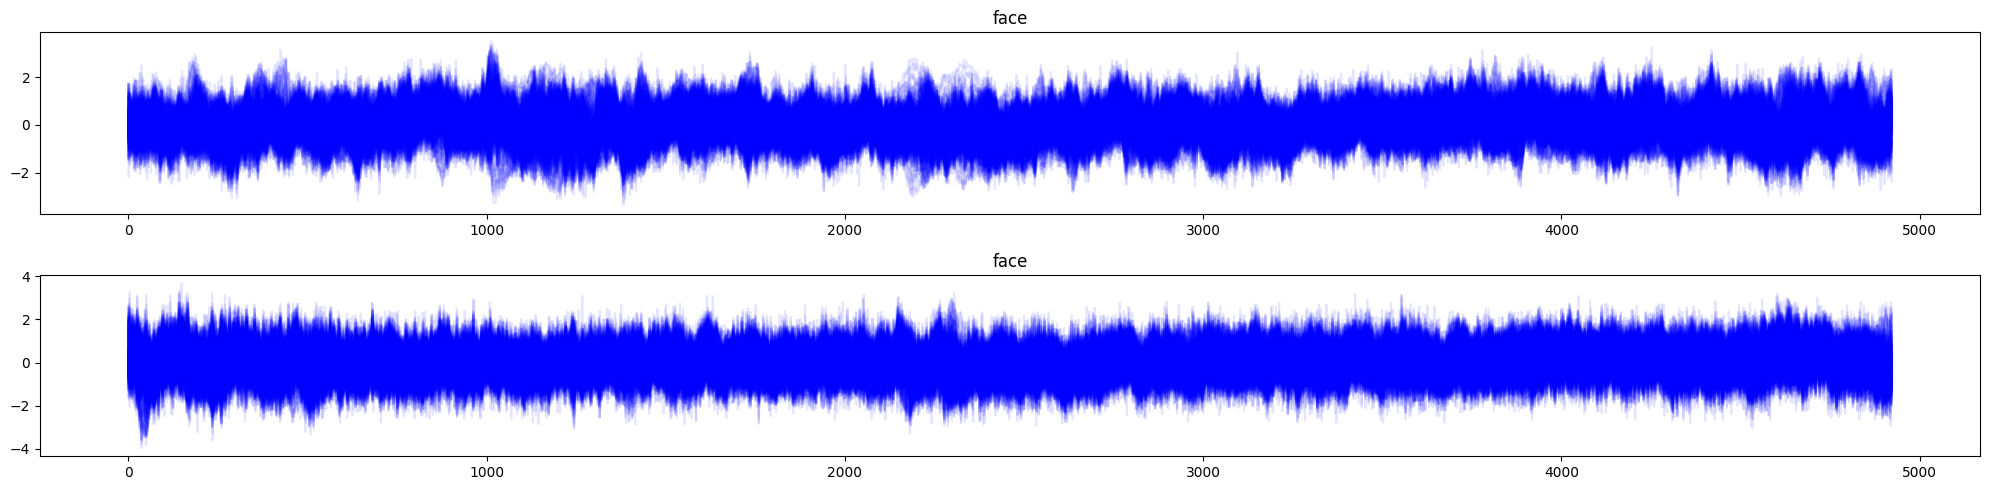

In [108]:
print(len(dataset), len(train_dataset), len(test_dataset))
fig, ax = plt.subplots(2, 1, figsize=(20, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, len(dataset))
    meg, label, x = dataset[np.random.randint(0, len(dataset))]
    for i in range(meg.shape[0]):
        ax.plot(meg[i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'{'house' if label == 43 else 'face'}')
print(meg.shape, label)
plt.tight_layout()
plt.show()

In [87]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
model = BrainEncoder([2]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
test_loss, test_acc = [], []
train_loss, train_acc = [], []
for epoch in range(30):
    model.train()
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}', unit='batch', leave=False)
    lossinho = 0
    correct = 0
    total = 0
    for idx, (data, target) in enumerate(progress_bar):
        target = [0 if i == 43 else 1 for i in target]
        #data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
        data = data[:, :271, :]
        data, target = data.to(device), torch.tensor(target).to(device)
        output = model(data, subject_idxs=np.zeros_like(target))
        loss = loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lossinho += loss.item()
        progress_bar.set_postfix(loss=lossinho/(idx+1))

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch {epoch+1} Loss: {lossinho/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
    train_loss.append(lossinho/len(train_loader))
    train_acc.append(accuracy)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        lossinho = 0
        for data, target in test_loader:
            target = [0 if i == 43 else 1 for i in target]
            #data = data.reshape(data.shape[0], 1, data.shape[1], data.shape[2])
            data = data[:, :271, :]
            data, target = data.to(device), torch.tensor(target).to(device)
            output = model(data, subject_idxs=np.zeros_like(target))
            loss = loss_fn(output, target)
            lossinho += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Accuracy: {accuracy:.2f}%, Loss: {lossinho/len(test_loader):.4f}')
    test_loss.append(lossinho/len(test_loader))
    test_acc.append(accuracy)

Epoch 1 Loss: 0.6937, Accuracy: 50.00%
Accuracy: 48.75%, Loss: 0.6935


Epoch 2 Loss: 0.6745, Accuracy: 67.50%
Accuracy: 48.75%, Loss: 0.6934


Epoch 3 Loss: 0.6538, Accuracy: 71.56%
Accuracy: 48.75%, Loss: 0.6933


Epoch 4 Loss: 0.6187, Accuracy: 75.94%
Accuracy: 51.25%, Loss: 0.6931


Epoch 5 Loss: 0.5717, Accuracy: 76.88%
Accuracy: 57.50%, Loss: 0.6925


Epoch 6 Loss: 0.5069, Accuracy: 81.56%
Accuracy: 56.25%, Loss: 0.6913


Epoch 7 Loss: 0.4325, Accuracy: 85.31%
Accuracy: 60.00%, Loss: 0.6898


Epoch 8 Loss: 0.3310, Accuracy: 93.75%
Accuracy: 53.75%, Loss: 0.6857


Epoch 9 Loss: 0.2315, Accuracy: 95.62%
Accuracy: 60.00%, Loss: 0.6805


Epoch 10 Loss: 0.1314, Accuracy: 98.44%
Accuracy: 62.50%, Loss: 0.6689


Epoch 11 Loss: 0.0571, Accuracy: 100.00%
Accuracy: 57.50%, Loss: 0.6850


Epoch 12 Loss: 0.0243, Accuracy: 100.00%
Accuracy: 56.25%, Loss: 0.7593


Epoch 13 Loss: 0.0091, Accuracy: 100.00%
Accuracy: 55.00%, Loss: 0.8648


Epoch 14 Loss: 0.0038, Accuracy: 100.00%
Accuracy: 60.00%, Loss: 1.0730


Epoch 15 Loss: 0.0021, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.1814


Epoch 16 Loss: 0.0010, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.2175


Epoch 17 Loss: 0.0007, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.2971


Epoch 18 Loss: 0.0008, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.4095


Epoch 19 Loss: 0.0004, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.5305


Epoch 20 Loss: 0.0004, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.6358


Epoch 21 Loss: 0.0003, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.6872


Epoch 22 Loss: 0.0003, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7083


Epoch 23 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7168


Epoch 24 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 65.00%, Loss: 1.7301


Epoch 25 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7316


Epoch 26 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7463


Epoch 27 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7251


Epoch 28 Loss: 0.0002, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7335


Epoch 29 Loss: 0.0001, Accuracy: 100.00%
Accuracy: 62.50%, Loss: 1.7367


Epoch 30 Loss: 0.0001, Accuracy: 100.00%
Accuracy: 63.75%, Loss: 1.7554


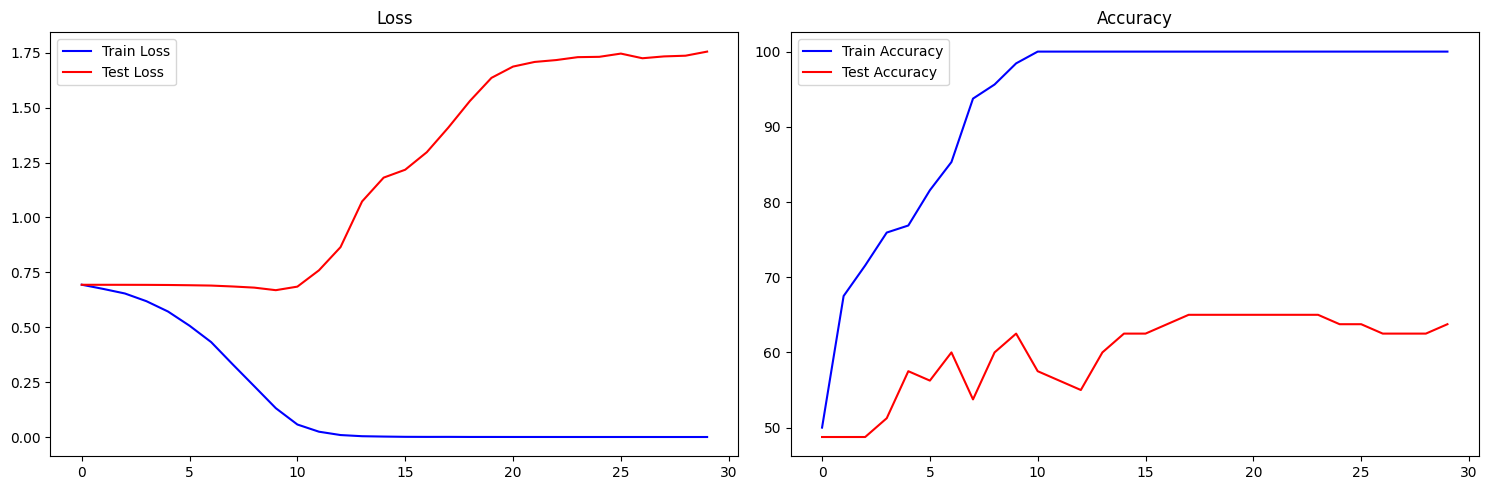

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(train_loss, label='Train Loss', color='blue')
ax[0].plot(test_loss, label='Test Loss', color='red')
ax[0].legend()
ax[0].set_title('Loss')
ax[1].plot(train_acc, label='Train Accuracy', color='blue')
ax[1].plot(test_acc, label='Test Accuracy', color='red')
ax[1].legend()
ax[1].set_title('Accuracy')
plt.tight_layout()
plt.show()